In [ ]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import librosa
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics  import f1_score, precision_score, recall_score
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score,average_precision_score,f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier

from scipy.io import wavfile as wav
import matplotlib.pyplot as plt

In [ ]:
# data visualizzation

In [ ]:
audio_file_path = '/Users/massimo/Desktop/Data Mining/Progetto/archive/fold1/7383-3-1-0.wav'

In [ ]:
librosa_audio_data, librosa_sample_rate = librosa.load(audio_file_path)

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(librosa_audio_data)

In [ ]:
wave_sample_rate, wave_audio = wav.read(audio_file_path)

In [ ]:
wave_audio

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(wave_audio)

In [ ]:
mfcc_feat = librosa.feature.mfcc(y=librosa_audio_data, sr=librosa_sample_rate, n_mfcc = 40)

print(mfcc_feat.shape)

In [ ]:
mfcc_feat

In [ ]:
# dataset

In [ ]:
audio_dataset_path = '/Users/massimo/Desktop/Data Mining/Progetto/archive'
metadata_path = pd.read_csv('/Users/massimo/Desktop/Data Mining/Progetto/archive/UrbanSound8K.csv')

In [ ]:
metadata_path.head(10)

In [ ]:
#function for feature extraction
def audio_feature_extraction(file):
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast')
    mfcc_feat = librosa.feature.mfcc(y=audio, sr= sample_rate, n_mfcc=40)
    mfcc_scaled_features = np.mean(mfcc_feat.T, axis =0)
    return mfcc_scaled_features

In [ ]:
# iterate through each file and extract features
extracted_features = []
for index_num, row in tqdm(metadata_path.iterrows()):
    #print(row[1][-1])
    #break
    #../input/urbansound8k/fold1/101415-3-0-2.wav
    #file_name = os.path.join(os.path.abspath(audio_dataset_path),'fold'+str(row[1][5])+'/',str(row[1][0]))
    #print(file_name)
    file_name = os.path.join(os.path.abspath(audio_dataset_path),'fold'+str(row["fold"])+'/',str(row['slice_file_name']))
    final_class_labels = row['class']#row[1][-1]
    data = audio_feature_extraction(file_name)
    extracted_features.append([data, final_class_labels])

In [ ]:
### converting extracted_features to Pandas dataframe
extracted_features_df=pd.DataFrame(extracted_features,columns=['feature','class'])
extracted_features_df
# save dataset
extracted_features_df.to_csv('/Users/massimo/Desktop/Data Mining/Progetto/archive/extracted_features_df.csv')

In [ ]:
# read dataset
extracted_features_df = pd.read_csv('/Users/massimo/Desktop/Data Mining/Progetto/archive/extracted_features_df.csv')
extracted_features_df=pd.DataFrame(extracted_features,columns=['feature','class'])
extracted_features_df

In [ ]:
### Split the dataset into independent and dependent dataset
X=np.array(extracted_features_df['feature'].tolist())
y=np.array(extracted_features_df['class'].tolist())

In [379]:
X.shape

(8732, 40)

In [380]:
y

array(['dog_bark', 'children_playing', 'children_playing', ...,
       'car_horn', 'car_horn', 'car_horn'], dtype='<U16')

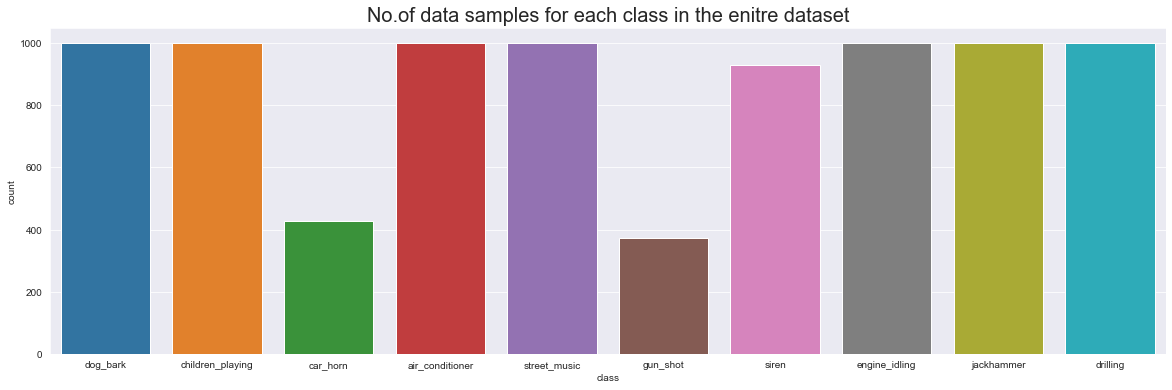

In [381]:
fig = plt.figure(figsize=(20,6))
plt.title("No.of data samples for each class in the enitre dataset", fontsize= 20)
sns.countplot(x ='class', data = extracted_features_df )
plt.show()

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X,y,random_state = 6, test_size=0.2)
x_train.shape, x_test.shape

In [299]:
# test dataset originale, non bilanciato
# x_train & x_test

#Define cross-valudation method
n_folds = 10
skf = StratifiedKFold(n_folds, shuffle=True)

#Defnie parameters for features selection
#SelectKBest prameters
#Number of feature selected
TOP_K = [10, 20, 30, 40]
#Score function for evaluation
SCORE_F = [f_classif]

#Define scoring metrics
scoring = ['accuracy', 'precision_micro', 'recall_micro', 'f1_micro']

# category
category_id_df = ['air_conditioner', 'car_horn', 'children_playing', 'dog_bark', 'drilling', 'enginge_idling', 'gun_shot', 'jackhammer', 'siren','street_music']

#x_train, x_test, y_train, y_test
def plot_cm(y_test, predicted):
    conf_mat = confusion_matrix(y_test, predicted)
    fig, ax = plt.subplots(figsize=(10, 10))
    sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=category_id_df, yticklabels=category_id_df)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

In [300]:
#from sklearn import preprocessing
#min_max_scaler = preprocessing.MinMaxScaler()
#x_norm = min_max_scaler.fit_transform(X)

In [301]:
# Evaluation of Linear Support Vector Classification
# KNeighborsClassifier().get_params().keys()
pipe = Pipeline([('clf',KNeighborsClassifier())])
grid = {
    'clf__n_neighbors': (np.arange(3,50,1))
}
grid_search = GridSearchCV(pipe, param_grid=grid, scoring=scoring, refit="f1_micro", n_jobs=-1, cv=skf)
model = grid_search.fit(X=X, y=y)

print(grid_search.best_params_)

{'clf__n_neighbors': 3}


In [302]:
model.best_estimator_

Pipeline(steps=[('clf', KNeighborsClassifier(n_neighbors=3))])

In [303]:
model.best_score_

0.8791798710881492

In [304]:
#Defnie parameters for features selection
pipe_fsel = Pipeline([('selectkbest', SelectKBest()),('clf',KNeighborsClassifier())])

grid_fsel = {
    'clf__n_neighbors': [3],
    'selectkbest__score_func': SCORE_F,
    'selectkbest__k': TOP_K
}

grid_search = GridSearchCV(pipe_fsel, param_grid=grid_fsel, scoring=scoring, refit="f1_micro", n_jobs=-1, cv=skf)
model_fsel = grid_search.fit(X=X, y=y)

In [305]:
model_fsel.best_estimator_

Pipeline(steps=[('selectkbest', SelectKBest(k=40)),
                ('clf', KNeighborsClassifier(n_neighbors=3))])

In [306]:
model_fsel.best_score_

0.878265849892923

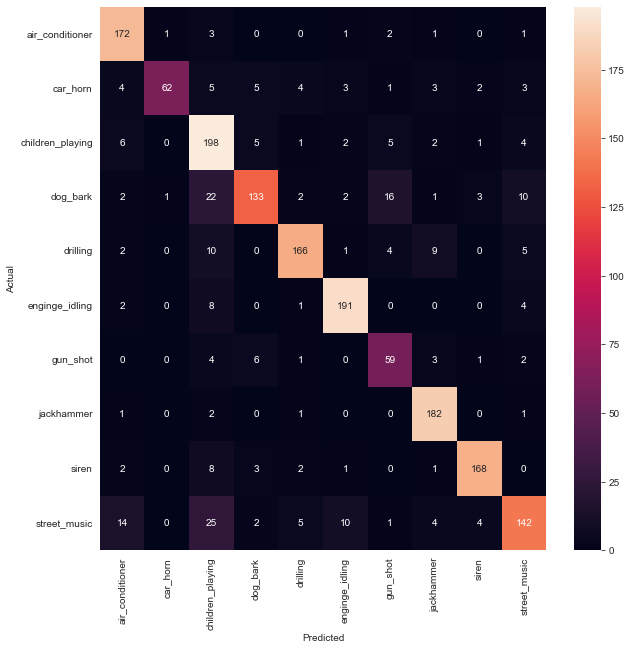

In [307]:
# matrix
select_k = SelectKBest(f_classif, k=40)
selected_features = select_k.fit_transform(x_train, y_train)
selected_features_test = select_k.transform(x_test)

clf = KNeighborsClassifier(n_neighbors=3).fit(selected_features, y_train)
predicted = clf.predict(selected_features_test)

plot_cm(y_test, predicted)

In [ ]:
#################################################

In [308]:
# Evaluation of RandomForestClassifier
# RandomForestClassifier().get_params().keys()
pipe = Pipeline([('clf',RandomForestClassifier())])
grid = {
   #'clf__max_depth': (np.arange(3,50,1)),
    'clf__n_estimators': (np.arange(3,70,1))
}
grid_search = GridSearchCV(pipe, param_grid=grid, scoring=scoring, refit="f1_micro", n_jobs=-1, cv=skf)
model = grid_search.fit(X=X, y=y)

print(grid_search.best_params_)

{'clf__n_estimators': 67}


In [309]:
model.best_estimator_

Pipeline(steps=[('clf', RandomForestClassifier(n_estimators=67))])

In [310]:
model.best_score_

0.8978484984311969

In [311]:
pipe_fsel = Pipeline([('selectkbest', SelectKBest()), ('clf', RandomForestClassifier())])

grid_fsel = {
    'clf__n_estimators': [67] ,
    'selectkbest__score_func': SCORE_F,
    'selectkbest__k': TOP_K
}

grid_search = GridSearchCV(pipe_fsel, param_grid=grid_fsel, scoring=scoring, refit="f1_micro", n_jobs=-1, cv=skf)
model_fsel = grid_search.fit(X=X, y=y)

In [312]:
model_fsel.best_estimator_

Pipeline(steps=[('selectkbest', SelectKBest(k=40)),
                ('clf', RandomForestClassifier(n_estimators=67))])

In [313]:
model_fsel.best_score_

0.8914347537752194

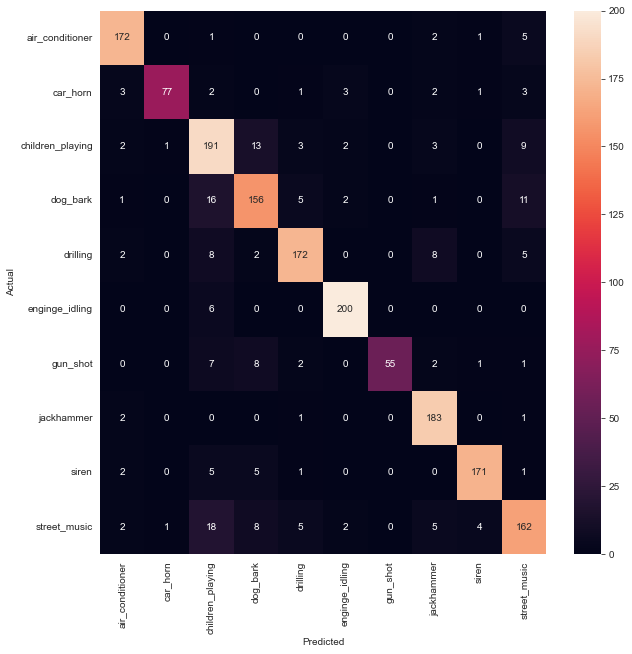

In [314]:
# matrix
select_k = SelectKBest(f_classif, k=40)
selected_features = select_k.fit_transform(x_train, y_train)
selected_features_test = select_k.transform(x_test)

clf = RandomForestClassifier(n_estimators=67).fit(selected_features, y_train)
predicted = clf.predict(selected_features_test)

plot_cm(y_test, predicted)

In [ ]:
#####################################

In [317]:
# Evaluation of Support Vector Machines
# SVC().get_params().keys()
pipe = Pipeline([('clf',SVC())])
grid = {
    'clf__C':[10, 1e2, 1e3],
    'clf__gamma':[1e-3, 1e-4, 5e-3]
}
grid_search = GridSearchCV(pipe, param_grid=grid, scoring=scoring, refit="f1_micro", n_jobs=-1, cv=skf)
model = grid_search.fit(X=X, y=y)

print(grid_search.best_params_)

{'clf__C': 100.0, 'clf__gamma': 0.0001}


In [319]:
model.best_estimator_

Pipeline(steps=[('clf', SVC(C=100.0, gamma=0.0001))])

In [320]:
model.best_score_

0.923843318890383

In [323]:
pipe_fsel = Pipeline([('selectkbest', SelectKBest()), ('clf', SVC())])

grid_fsel = {
    'clf__C':[100],
    'clf__gamma':[0.0001],
    'selectkbest__score_func': SCORE_F,
    'selectkbest__k': TOP_K
}

grid_search = GridSearchCV(pipe_fsel, param_grid=grid_fsel, scoring=scoring, refit="f1_micro", n_jobs=-1, cv=skf)
model_fsel = grid_search.fit(X=X, y=y)

In [324]:
model_fsel.best_estimator_

Pipeline(steps=[('selectkbest', SelectKBest(k=40)),
                ('clf', SVC(C=100, gamma=0.0001))])

In [325]:
model_fsel.best_score_

0.9247582575143971

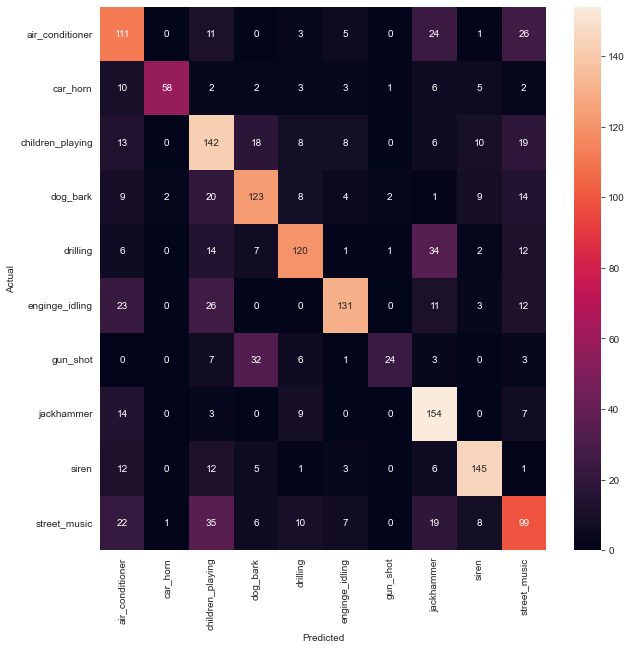

In [326]:
# matrix
select_k = SelectKBest(f_classif, k=40)
selected_features = select_k.fit_transform(x_train, y_train)
selected_features_test = select_k.transform(x_test)

clf = SVC(C=100, gamma=0.0001).fit(selected_features, y_train)
predicted = clf.predict(selected_features_test)

plot_cm(y_test, predicted)

In [ ]:
#######################################

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratio', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])

In [335]:
# Evaluation of LogisticRegression
#LogisticRegression().get_params().keys()
pipe = Pipeline([('clf',LogisticRegression())])

grid = {
    #'clf__multi_class': ['ovr'],
    'clf__solver': ['lbfgs', 'liblinear'],
    'clf__max_iter': [1000]
}

grid_search = GridSearchCV(pipe, param_grid=grid, scoring=scoring, refit="f1_micro", n_jobs=-1, cv=skf)
model = grid_search.fit(X=X, y=y)

print(grid_search.best_params_)

{'clf__max_iter': 1000, 'clf__multi_class': 'ovr', 'clf__solver': 'lbfgs'}


In [336]:
model.best_estimator_

Pipeline(steps=[('clf', LogisticRegression(max_iter=1000, multi_class='ovr'))])

In [337]:
model.best_score_

0.5924204654771547

In [331]:
pipe_fsel = Pipeline([('selectkbest', SelectKBest()), ('clf', LogisticRegression())])

grid_fsel = {
    #'clf__multi_class': ['ovr'],
    'clf__solver': [ 'liblinear'],
    'clf__max_iter': [1000],
    'selectkbest__score_func': SCORE_F,
    'selectkbest__k': TOP_K
}

grid_search = GridSearchCV(pipe_fsel, param_grid=grid_fsel, scoring=scoring, refit="f1_micro", n_jobs=-1, cv=skf)
model_fsel = grid_search.fit(X=X, y=y)

In [332]:
model_fsel.best_estimator_

Pipeline(steps=[('selectkbest', SelectKBest(k=40)),
                ('clf', LogisticRegression(max_iter=1000, solver='liblinear'))])

In [333]:
model_fsel.best_score_

0.5903590029908179

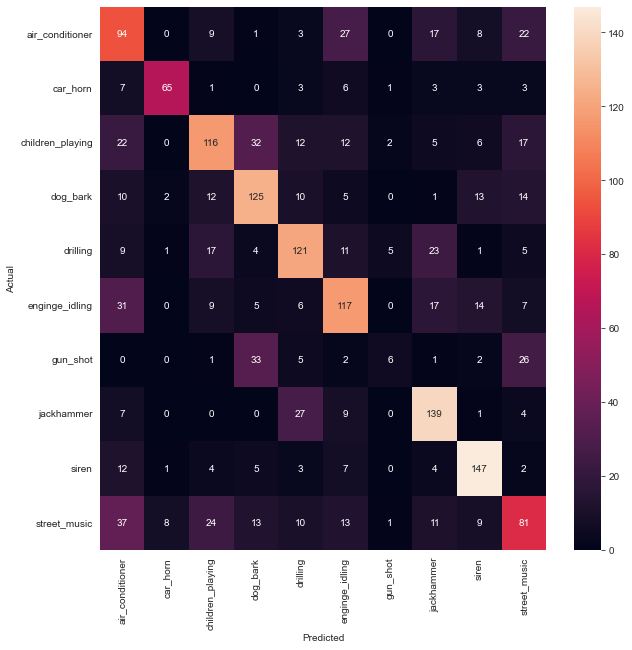

In [334]:
# matrix
select_k = SelectKBest(f_classif, k=40)
selected_features = select_k.fit_transform(x_train, y_train)
selected_features_test = select_k.transform(x_test)

clf = LogisticRegression(max_iter=1000, solver='liblinear').fit(selected_features, y_train)
predicted = clf.predict(selected_features_test)

plot_cm(y_test, predicted)

In [ ]:
#############################################################

In [341]:
from sklearn.naive_bayes import GaussianNB
GaussianNB().get_params().keys()

dict_keys(['priors', 'var_smoothing'])

In [342]:
#Gaussian Naive Bayes
#GaussianNB().get_params().keys()
pipe = Pipeline([('clf',GaussianNB())])
grid = {
}

grid_search = GridSearchCV(pipe, param_grid=grid, scoring=scoring, refit="f1_micro", n_jobs=-1, cv=skf)
model = grid_search.fit(X=X, y=y)

print(grid_search.best_params_)

{}


In [343]:
model.best_estimator_

Pipeline(steps=[('clf', GaussianNB())])

In [344]:
model.best_score_

0.4775565463786465

In [345]:
pipe_fsel = Pipeline([('selectkbest', SelectKBest()), ('clf', GaussianNB())])

grid_fsel = {
    'selectkbest__score_func': SCORE_F,
    'selectkbest__k': TOP_K
}
grid_search = GridSearchCV(pipe_fsel, param_grid=grid_fsel, scoring=scoring, refit="f1_micro", n_jobs=-1, cv=skf)
model_fsel = grid_search.fit(X=X, y=y)

In [346]:
model_fsel.best_estimator_

Pipeline(steps=[('selectkbest', SelectKBest(k=20)), ('clf', GaussianNB())])

In [347]:
model_fsel.best_score_

0.4910675201375619

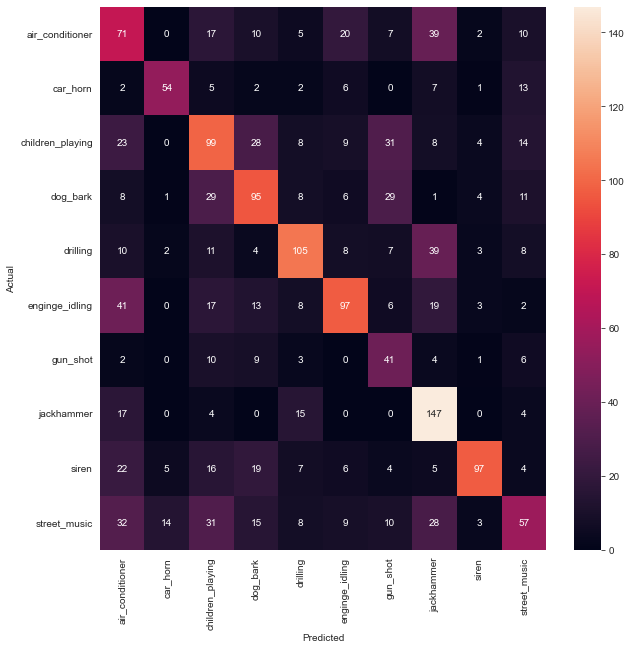

In [348]:
#matrix
select_k = SelectKBest(f_classif, k=20)
selected_features = select_k.fit_transform(x_train, y_train)
selected_features_test = select_k.transform(x_test)

clf = GaussianNB().fit(selected_features, y_train)
predicted = clf.predict(selected_features_test)

plot_cm(y_test, predicted)

In [ ]:
########################################

In [372]:
# AdaBoostClassifier
# AdaBoostClassifier().get_params().keys()
pipe = Pipeline([('clf',AdaBoostClassifier())])
grid = {
    'clf__base_estimator': [RandomForestClassifier(n_estimators=67)],
    'clf__n_estimators':(np.arange(1,100,5))
}
grid_search = GridSearchCV(pipe, param_grid=grid, scoring=scoring, refit="f1_micro", n_jobs=-1, cv=skf)
model = grid_search.fit(X=X, y=y)

print(grid_search.best_params_)

{'clf__base_estimator': RandomForestClassifier(n_estimators=67), 'clf__n_estimators': 86}


In [373]:
model.best_estimator_

Pipeline(steps=[('clf',
                 AdaBoostClassifier(base_estimator=RandomForestClassifier(n_estimators=67),
                                    n_estimators=86))])

In [374]:
model.best_score_

0.8976182238054422

In [375]:
pipe_fsel = Pipeline([('selectkbest', SelectKBest()), ('clf', AdaBoostClassifier())])

grid_fsel = {
    'clf__base_estimator': [RandomForestClassifier(n_estimators=67)],
    'clf__n_estimators': [86],
    'selectkbest__score_func': SCORE_F,
    'selectkbest__k': TOP_K
}

grid_search = GridSearchCV(pipe_fsel, param_grid=grid_fsel, scoring=scoring, refit="f1_micro", n_jobs=-1, cv=skf)
model_fsel = grid_search.fit(X=X, y=y)

In [376]:
model_fsel.best_estimator_

Pipeline(steps=[('selectkbest', SelectKBest(k=40)),
                ('clf',
                 AdaBoostClassifier(base_estimator=RandomForestClassifier(n_estimators=67),
                                    n_estimators=86))])

In [377]:
model_fsel.best_score_

0.8912052655169973

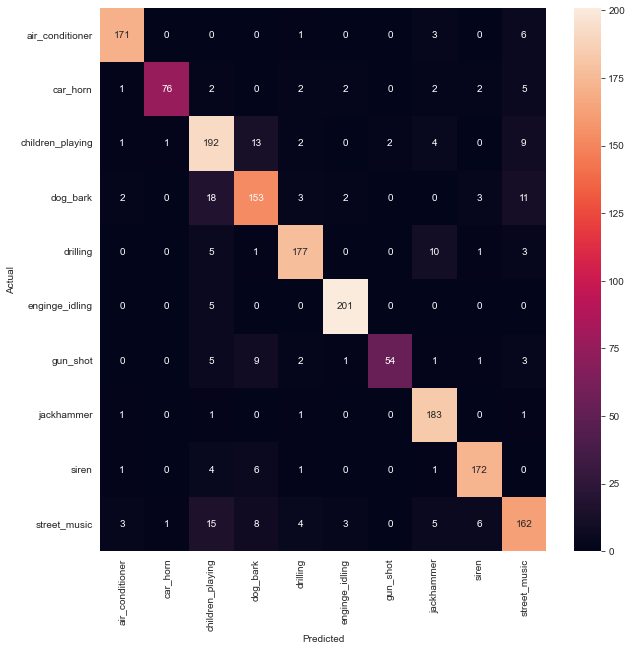

In [378]:
#matrix
select_k = SelectKBest(f_classif, k=40)
selected_features = select_k.fit_transform(x_train, y_train)
selected_features_test = select_k.transform(x_test)

clf = AdaBoostClassifier(base_estimator=RandomForestClassifier(n_estimators=67),n_estimators=86).fit(selected_features, y_train)
predicted = clf.predict(selected_features_test)

plot_cm(y_test, predicted)

In [ ]:
##################################################

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x_train,y_train,random_state = 6, test_size=0.15)
x_train.shape, y_train.shape

In [ ]:
x_test

In [ ]:
fig = plt.figure(figsize=(20,6))
plt.title("No.of data samples for each class in the training dataset", fontsize= 20)
sns.countplot(y=y_train)
plt.show()

In [ ]:
temp_gun = []
temp_car = []

for i in range(len(y_train)):

    if y_train[i] == 'car_horn':
        temp_car.append(x_train[i])

    if y_train[i] == 'gun_shot':
        temp_gun.append(x_train[i])

In [ ]:
target_size = 685

t_s_car = target_size - len(temp_car)
t_s_gun = target_size - len(temp_gun)

print(t_s_car, t_s_gun)

In [ ]:
upsample_car = []
upsample_gun = []

y_up_car = []
y_up_gun = []

In [ ]:
from numpy import random

for i in range(t_s_car):
    ind = random.randint(0, len(temp_car)-1)
    upsample_car.append(temp_car[ind])
    y_up_car.append('car_horn')

for i in range(t_s_gun):
    ind = random.randint(0, len(temp_gun)-1)
    upsample_gun.append(temp_gun[ind])
    y_up_gun.append('gun_shot')

In [ ]:
x_train = list(x_train)
x_train = x_train + upsample_car + upsample_gun
print(len(x_train))

In [ ]:
y_train = list(y_train)
y_train = y_train + y_up_car + y_up_gun
print(len(y_train))

In [ ]:
x_train = np.array(x_train)
y_train = np.array(y_train)

print(x_train.shape, y_train.shape)

In [ ]:
fig = plt.figure(figsize=(20,6))
plt.title("No.of data samples for each class in the training dataset after upsampling", fontsize= 20)
sns.countplot(y=y_train)
plt.show()

In [ ]:
x_train_n = x_train

In [ ]:
y_train_n = y_train

In [ ]:
print(x_train_n.shape, x_test.shape, y_train_n.shape, y_test.shape)

In [ ]:
x_val.shape , y_val.shape

In [ ]:
x_train_n1 = list(x_train_n)  + list(x_val)
y_train_n1 = list(y_train_n) + list(y_val)

x_train_n1 = np.array(x_train_n1)
y_train_n1 = np.array(y_train_n1)

In [ ]:
x_train_n1.shape , y_train_n1.shape

In [ ]:
y_train_pred_ada = clf_ada.predict(x_train_n1)

print("Training precision score is :-", precision_score(y_train_n1, y_train_pred_ada, average="macro"))
print("Training recall is :-", recall_score(y_train_n1, y_train_pred_ada, average="macro"))

In [ ]:
print("Testing accuracy is :-", clf_ada.score(x_test, y_test))

y_pred_ada = clf_ada.predict(x_test)
print()
print("Testing precision score is :-", precision_score(y_test, y_pred_ada, average="macro"))
print("Testing recall is :-", recall_score(y_test, y_pred_ada, average="macro"))
print()
print("Testing f1 score is :-", f1_score(y_test, y_pred_ada, average="macro"))

In [ ]:
import seaborn as sns

confusion_mat = confusion_matrix(y_test, y_pred_ada)

plt.figure(figsize=(10,4))

plt.xlabel("Predicted class")
plt.ylabel("True class")

sns.heatmap(confusion_mat, annot=True, cmap="Blues", xticklabels = ['air_conditioner', 'car_horn', 'children_playing', 'dog_bark', 'drilling', 'enginge_idling', 'gun_shot', 'jackhammer', 'siren','street_music'],
           yticklabels=['air_conditioner', 'car_horn', 'children_playing', 'dog_bark', 'drilling', 'enginge_idling', 'gun_shot', 'jackhammer', 'siren','street_music'])
plt.show()

In [ ]:
print(classification_report(y_test, y_pred_ada))